## 1. Imports

In [1]:
#Importamos librerías
import sys
import os 

import numpy as np # Arrays
import pandas as pd # Series and Dataframes

import matplotlib.pyplot as plt 
import seaborn as sns # Advanced Plotting 
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
# from google.colab import files #para importar desde google
# from google.colab import drive

pd.options.display.max_rows = 100
plt.style.use('ggplot') # Beautify Plots 

In [2]:
#A nivel de modelos
from sklearn import model_selection
import xgboost as xgb #este es para hacer decision trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics # model evaluation metrics

In [3]:
#Estas funciones son para hacer transformaciones
from scipy import stats
from datetime import datetime

In [4]:
#librería para hacer números random
import random

In [5]:
#json se utiliza para bd de nosql, pero es parecido a los diccionarios de phyton. normalmente tiene esta forma {'ggg`: 'zzzz'}
#Cuando se importa de googlemaps, eso está guardado en un json

import random
import json
from pandas import json_normalize

In [6]:
#para poder ver los datos tenemos que montar el drive
# drive.mount('/content/gdrive')

#MODELIZACIÓN

In [7]:
df_modelo1=pd.read_pickle(r"C:\Users\Usuario\OneDrive\Workplace\Portfolio_Projects\TFM_DSC_Easy_Money\data\df_modelo_pk")

## MLC4.1: Train / Test Split

Identificamos que aproximadamente el 80% cae sobre el 2019-01. Se toma la decisión de hacer en entrenamiento con valores del 2018 y la validación con valores de 2019.

Transformamos las dos últimas variables que nos faltan a números, que son las fechas tanto de entrada como mes de venta. 

In [8]:
df_modelo1['año_entrada'] = df_modelo1['entry_month'].dt.year
df_modelo1['mes_entrada'] = df_modelo1['entry_month'].dt.month

In [9]:
df_modelo1['año_venta'] = df_modelo1['month_sale'].dt.year
df_modelo1['mes_venta'] = df_modelo1['month_sale'].dt.month

In [10]:
df_modelo1['mes_venta']

0         5
1         5
2         5
3         4
4         4
         ..
915788    5
915789    5
915790    5
915791    5
915792    5
Name: mes_venta, Length: 915793, dtype: int64

In [11]:
df_modelo1 = df_modelo1.drop(['entry_month', 'month_sale', 'entry_date'], axis=1)

In [12]:
df_modelo1 = df_modelo1.drop(['pk_sale', 'pk_cid'],axis=1) #Viendo en el primer decision tree, estas variables cuando son seleccionadas no aportan aprendizaje
# Se hace la prueba para corroborar esto.

In [13]:
print(df_modelo1.columns)

Index(['Unnamed: 0', 'age', 'net_margin_log', 'salary_scaled',
       'compro_nuevos_productos', 'product_desc_credit_card',
       'product_desc_debit_card', 'product_desc_em_acount',
       'product_desc_emc_account', 'product_desc_funds',
       ...
       'Provincia_Toledo', 'Provincia_Valencia', 'Provincia_Valladolid',
       'Provincia_Vizcaya', 'Provincia_Zamora', 'Provincia_Zaragoza',
       'año_entrada', 'mes_entrada', 'año_venta', 'mes_venta'],
      dtype='object', length=166)


## Oversampling de nuestra variable Target

In [14]:
positive_indices = df_modelo1[df_modelo1['compro_nuevos_productos'] == 1].index
negative_indices = df_modelo1[df_modelo1['compro_nuevos_productos'] == 0].index

In [15]:
num_positive_cases = len(positive_indices)
num_negative_cases = len(negative_indices)

In [16]:
print(num_positive_cases, num_negative_cases)

35304 880489


In [17]:
oversampled_positive_indices = np.random.choice(positive_indices, size=num_negative_cases, replace=True)


In [18]:
oversampled_indices = np.concatenate([oversampled_positive_indices, negative_indices])


In [19]:
df_oversampled = df_modelo1.loc[oversampled_indices]


##Selección de la muestra

In [20]:
target_linked_features = ['compro_nuevos_productos'] #Seleccionamos las columnas que hicimos durante el dataunderstanding

In [21]:
df_val = df_oversampled[df_oversampled['año_venta'] == 2019]
df_dev = df_oversampled[df_oversampled['año_venta'] < 2019]

In [22]:
df_dev.shape

(1264182, 166)

In [23]:
df_val.shape

(496796, 166)

In [24]:
df_val.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 496796 entries, 461936 to 914387
Columns: 166 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(7), uint8(157)
memory usage: 112.3 MB


In [25]:
df_dev.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 1264182 entries, 544058 to 893498
Columns: 166 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(7), uint8(157)
memory usage: 285.7 MB


In [26]:
df_dev_X = df_dev.drop(df_dev[target_linked_features], axis=1)
df_dev_y = df_dev.loc[:, target_linked_features]

In [27]:
df_val_X = df_val.drop(df_val[target_linked_features], axis=1)
df_val_y = df_val.loc[:, target_linked_features]

In [28]:
df_dev_X.head().T

,544058,581172,485836,688877,157532
Unnamed: 0,544058.000000,581172.000000,485836.000000,688877.000000,157532.000000
age,37.000000,54.000000,38.000000,37.000000,53.000000
net_margin_log,4.262680,4.475062,4.310799,4.373238,4.169761
salary_scaled,0.004858,0.007792,0.000000,0.002747,0.006102
product_desc_credit_card,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
Provincia_Zaragoza,0.000000,1.000000,0.000000,0.000000,0.000000
año_entrada,2015.000000,2017.000000,2018.000000,2016.000000,2018.000000
mes_entrada,7.000000,7.000000,10.000000,6.000000,8.000000
año_venta,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000


In [29]:
df_dev_y.head().T

,544058,581172,485836,688877,157532
compro_nuevos_productos,1,1,1,1,1


##Random Holdout

In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        df_dev_X, # X 
                                        df_dev_y, # y
                                        test_size = 0.30, # tamaño del split aleatorio 
                                        random_state = 42
)

In [31]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 884927 entries, 879263 to 422775
Columns: 165 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(6), uint8(157)
memory usage: 193.3 MB


In [32]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 379255 entries, 683174 to 99889
Columns: 165 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(6), uint8(157)
memory usage: 82.8 MB


In [33]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,884927.0,465343.428417,254959.877096,1.000000,239181.500000,509051.000000,663824.000000,893498.000000
age,884927.0,34.526825,13.106123,2.000000,23.000000,32.000000,41.000000,102.000000
net_margin_log,884927.0,4.620052,1.220542,3.258097,4.123903,4.235555,4.366913,9.823762
salary_scaled,884927.0,0.002727,0.005813,0.000000,0.000000,0.002197,0.003769,1.000000
product_desc_credit_card,884927.0,0.028071,0.165177,0.000000,0.000000,0.000000,0.000000,1.000000


In [34]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,379255.0,465742.098817,255184.690820,0.000000,238842.00000,510223.000000,664412.000000,893409.000000
age,379255.0,34.526540,13.125399,2.000000,23.00000,32.000000,41.000000,102.000000
net_margin_log,379255.0,4.620024,1.220522,3.258097,4.12552,4.237001,4.366913,9.823762
salary_scaled,379255.0,0.002742,0.006569,0.000000,0.00000,0.002191,0.003765,1.000000
product_desc_credit_card,379255.0,0.028131,0.165349,0.000000,0.00000,0.000000,0.000000,1.000000


In [35]:
y_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
compro_nuevos_productos,884927.0,0.445846,0.497059,0.0,0.0,0.0,1.0,1.0


In [36]:
y_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
compro_nuevos_productos,379255.0,0.445647,0.497038,0.0,0.0,0.0,1.0,1.0


## Model definition
Para este segundo modelo se hará un Decision Tree

Importación de librería

In [37]:
!conda install python-graphviz -y

"conda" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

##Decision Tree

In [41]:
#DecisionTreeClassifier?

In [42]:
dt = DecisionTreeClassifier(
                        # criterion='gini',
                        # splitter='best',
                        max_depth=4, # Importante, regulará el sobreajuste
                        # min_samples_split=2,
                        # min_samples_leaf=1,
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None,
                        random_state=42,
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,  
                )

In [43]:
dt.fit(
    X=X_train, 
    y=y_train, 
    # sample_weight=None, 
    # check_input=True, 
    # X_idx_sorted=None
)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [44]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No Compra', 'Compra'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

In [45]:
import pydotplus
graph2 = pydotplus.graph_from_dot_data(dot_data)  

In [46]:
graph2.write_png("tree.png")

True

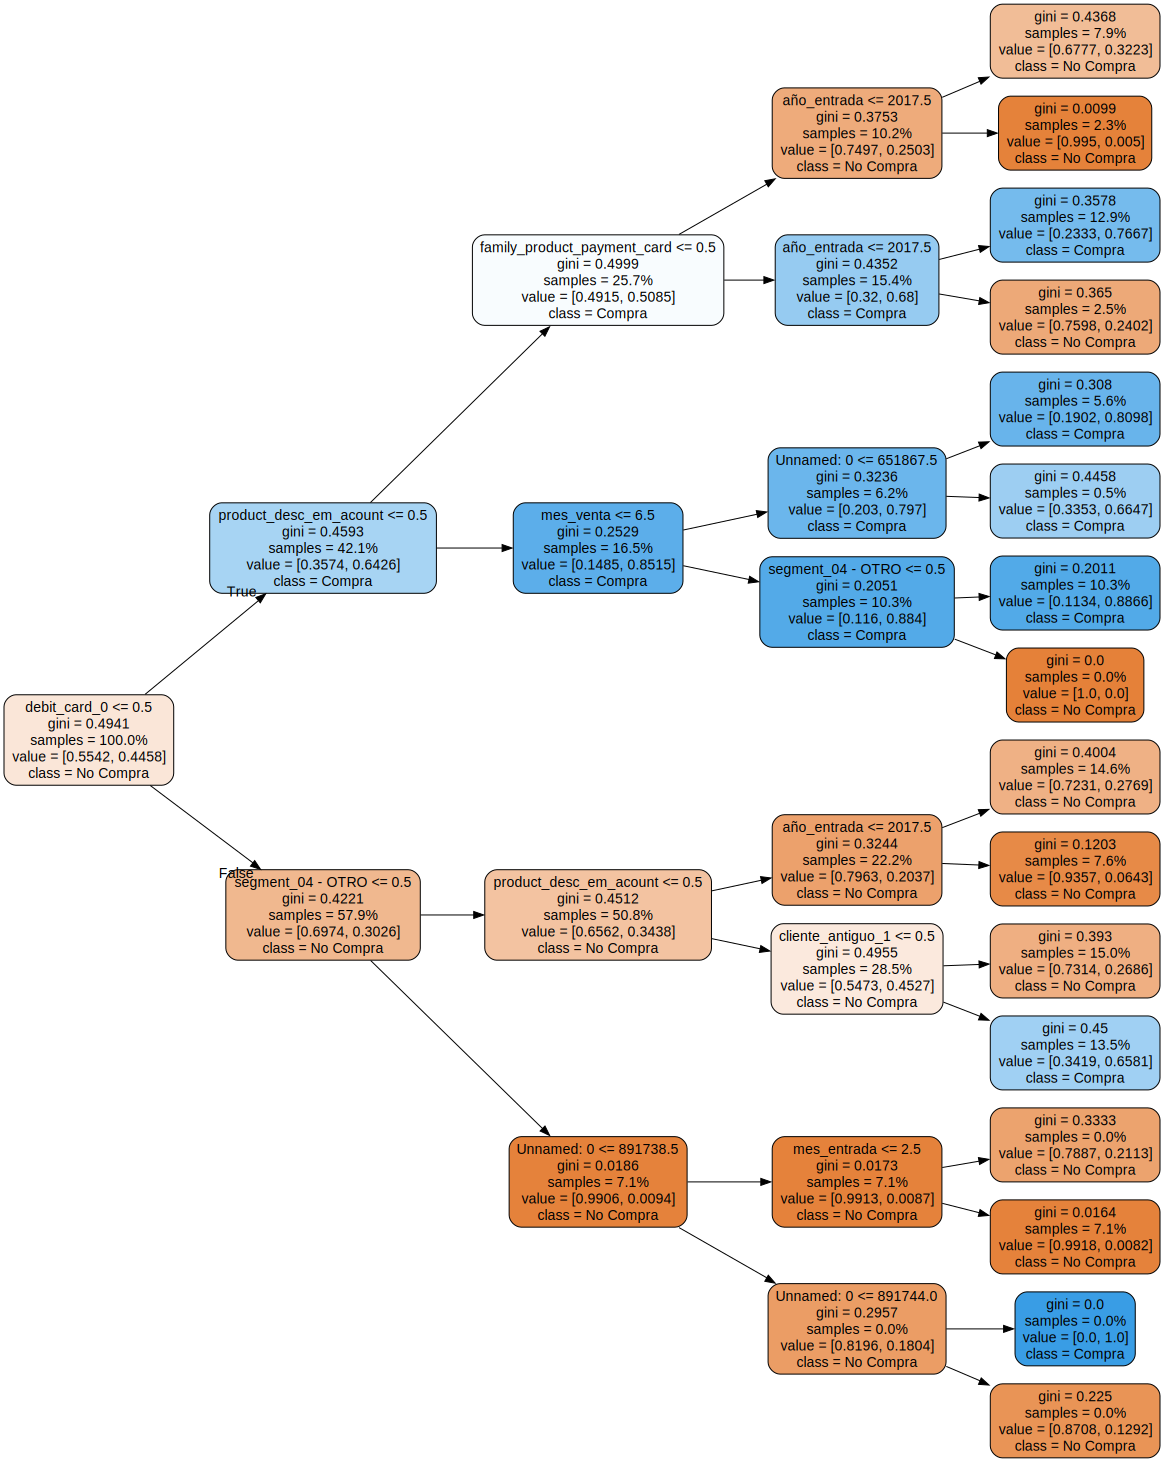

In [47]:
graphviz.Source(dot_data, format = 'png')

## Model evaluation

In [48]:
dt.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [49]:
y_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=['compro_nuevos_prod_Prediction'])

In [50]:
df_results = y_test.join(y_pred, how= 'inner')

In [51]:
df_results.head(10)

,compro_nuevos_productos,compro_nuevos_prod_Prediction
0,0,0
2,0,0
6,0,0
8,0,0
9,0,1
10,0,1
12,0,0
14,0,0
16,0,0
28,0,0


In [52]:
accuracy = dt.score(X_test, y_test)
print(accuracy)

0.7827741229515761


In [53]:
confusion_matrix = pd.crosstab(df_results['compro_nuevos_productos'],df_results['compro_nuevos_prod_Prediction'])

In [54]:
confusion_matrix

compro_nuevos_prod_Prediction,0,1
compro_nuevos_productos,,
0,172539,37702
1,379014,1053862


In [55]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [56]:
(TP+TN)/(TP+TN+FP+FN)

0.7463868975855037

In [57]:
metrics.accuracy_score(df_results['compro_nuevos_productos'],df_results['compro_nuevos_prod_Prediction'])

0.7463868975855037

In [58]:
# Aquí obtenemos el accuracy de forma directa
dt.score(X_test, y_test)

0.7827741229515761

In [59]:
dt.predict_proba(X_test)

array([[0.34190246, 0.65809754],
       [0.99504205, 0.00495795],
       [0.23330936, 0.76669064],
       ...,
       [0.34190246, 0.65809754],
       [0.23330936, 0.76669064],
       [0.73135057, 0.26864943]])

In [60]:
dt.predict_proba(X_test)[:,1]

array([0.65809754, 0.00495795, 0.76669064, ..., 0.65809754, 0.76669064,
       0.26864943])

In [61]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index = y_test.index, columns = ['compro_nuevos_productos'])

In [62]:
y_score

,compro_nuevos_productos
683174,0.658098
47845,0.004958
566086,0.766691
568523,0.766691
706192,0.658098
...,...
789804,0.268649
9142,0.064282
737687,0.658098
192054,0.766691


In [63]:
df_results = df_results.join(y_score, lsuffix='_test', rsuffix='_prediccion')

In [64]:
df_results.head()

,compro_nuevos_productos_test,compro_nuevos_prod_Prediction,compro_nuevos_productos_prediccion
0,0,0,0.064282
2,0,0,0.064282
6,0,0,0.064282
8,0,0,0.064282
9,0,1,0.658098


In [65]:
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

In [66]:
f1_score = 2 / (1/Precision + 1/Recall)

In [67]:
f1_score

0.834927350224208

In [68]:
Precision

0.965460568505374

In [69]:
Recall

0.7354872298789288

In [72]:
metrics.f1_score(y_test, y_pred)

0.7511418283753414

In [73]:
#AUC

metrics.roc_auc_score(df_results['compro_nuevos_productos_test'],df_results['compro_nuevos_productos_prediccion'])

0.8338079599015887

In [74]:
#ROC Curve
fpr, tpr, th = metrics.roc_curve(df_results['compro_nuevos_productos_test'],df_results['compro_nuevos_productos_prediccion'])

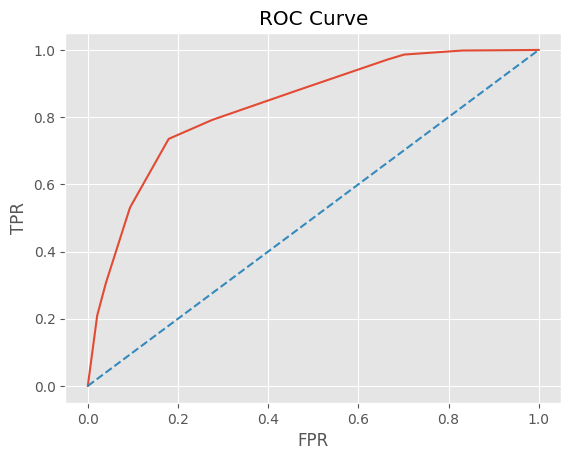

In [75]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle = '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [76]:
for i in range(1,21):
    # intanciar el modelo
    dt2 = DecisionTreeClassifier(max_depth = i, random_state = 42)

    # entrenar

    dt2.fit(X_train,y_train)

    # evaluar

    acc_train = dt2.score(X_train,y_train)
    acc_test = dt2.score(X_test, y_test)

    print(f"Profundidad del arbol: {i}, Acc.train: {np.round(acc_train,3)}, Acc.Test: {np.round(acc_test,3)}")

Profundidad del arbol: 1, Acc.train: 0.674, Acc.Test: 0.676
Profundidad del arbol: 2, Acc.train: 0.674, Acc.Test: 0.676
Profundidad del arbol: 3, Acc.train: 0.725, Acc.Test: 0.727
Profundidad del arbol: 4, Acc.train: 0.782, Acc.Test: 0.783
Profundidad del arbol: 5, Acc.train: 0.787, Acc.Test: 0.788
Profundidad del arbol: 6, Acc.train: 0.804, Acc.Test: 0.805
Profundidad del arbol: 7, Acc.train: 0.823, Acc.Test: 0.824
Profundidad del arbol: 8, Acc.train: 0.832, Acc.Test: 0.833
Profundidad del arbol: 9, Acc.train: 0.839, Acc.Test: 0.84
Profundidad del arbol: 10, Acc.train: 0.847, Acc.Test: 0.847
Profundidad del arbol: 11, Acc.train: 0.855, Acc.Test: 0.854
Profundidad del arbol: 12, Acc.train: 0.862, Acc.Test: 0.861
Profundidad del arbol: 13, Acc.train: 0.869, Acc.Test: 0.868
Profundidad del arbol: 14, Acc.train: 0.876, Acc.Test: 0.874
Profundidad del arbol: 15, Acc.train: 0.885, Acc.Test: 0.882
Profundidad del arbol: 16, Acc.train: 0.892, Acc.Test: 0.889
Profundidad del arbol: 17, Acc.tra

Nos vamos a ir con 8 entrenamientos para evitar que el modelo memorice.

##Modelo Final

In [77]:
dt_final = DecisionTreeClassifier(max_depth = 8, random_state = 42)

In [78]:
dt_final.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [79]:
dt_final.score(X_test,y_test)

0.8325928465016941

In [80]:
dt_final.score(df_val_X,df_val_y)

0.8381045741109027

In [83]:
metrics.f1_score(y_test, y_pred)

0.7511418283753414

In [84]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=['compro_nuevos_productos'])

In [85]:
df_results_final = y_test.join(y_test_pred, lsuffix='_test', rsuffix='_prediccion')

In [86]:
df_results_final['Success'] = (df_results_final['compro_nuevos_productos_test'] == df_results_final['compro_nuevos_productos_prediccion']).astype(int)

In [87]:
df_results_final['Success'].mean()

0.7463868975855037

In [88]:
confusion_matrix = pd.crosstab(df_results_final['compro_nuevos_productos_test'],df_results_final['compro_nuevos_productos_prediccion'])

In [89]:
confusion_matrix

compro_nuevos_productos_prediccion,0,1
compro_nuevos_productos_test,,
0,172539,37702
1,379014,1053862


#CONCLUSIÓN

En este cuarto modelo realizado con la muestra haciendo un oversampling, tenemos un modelo con un 74% de probabilidad de éxito.

Predice bastante bien los casos en los que el cliente compra, pero tenemos también un gran problema con los Falsos negativos

Se concluye que tanto en el undersampling como en el oversampling tenemos el mismo problema de los Falsos negativos, sin embargo en el oversampling, la cantidad de positivos que acierta es mucho mayor. 